## Simple Least-Squares Spectral Analysis implementation

__Phil Bull, 2022-05-04__

This notebook demonstrates a simple weighted LSSA implementation. This has the following steps:
 1. Take masked, complex 1D data $d$ and weight it by an inverse covariance matrix model, $C^{-1}$.
 1. For each wavenumber $\tau_i$:
   1. Fit the weighted data with a single complex sinusoid with wavenumber $\tau_i$, real amplitude $A_i$, and real phase $\phi_i$.

In [4]:
import numpy as np
import pylab as plt

In [28]:
def lssa_fit_modes(d, freqs, invcov=None, fit_amp_phase=True, tau=None, 
                   minimize_method='L-BFGS-B'):
    r"""
    Perform a weighted LSSA fit to masked complex 1D data.

    NOTE: The input data/covariance should have already had the flagged 
    channels removed. Use the `trim_flagged_channels()` function to do 
    this.
    
    The log-likelihood for each sinusoid takes the assumed form:
    
    $\log L_n = \tilde{x}^\dagger \tilde{C}^{-1} \tilde{x}$
    
    where $\tau_n = n / \Delta \nu$, $\Delta \nu$ is the bandwidth, and 
    
    $x = [d - A \exp(2 \pi i \nu \tau_n + i\phi)]$.

    The tilde denotes vectors/matrices from which the masked channels 
    (rows/columns) have been removed entirely.
    
    Parameters:
        d (array_like):
            Complex data array that has already had flagged channels removed.
        
        freqs (array_like):
            Array of frequency values, in MHz. Used to get tau values in 
            the right units only. Flagged channels must have already been 
            removed.
        
        invcov (array_like):
            Inverse of the covariance matrix (flagged channels must have been 
            removed before inverting).

        fit_amp_phase (bool, optional):
            If True, fits the (real) amplitude and (real) phase parameters 
            for each sinusoid. If False, fits the real and imaginary amplitudes.
        
        tau (array_like, optional):
            Array of tau modes to fit. If `None`, will use `fftfreq()` to 
            calculate the tau values. Units: nanosec.

        minimize_method (str, optional):
            Which SciPy minimisation method to use. Default: `'L-BFGS-B'`.
    
    Returns:
        tau (array_like):
            Wavenumbers, calculated as tau_n = n / L, in nanoseconds.
            
        param1, param2 (array_like):
            If `fit_amp_phase` is True, these are the best-fit amplitude and 
            phase of the sinusoids. Otherwise, they are the real and imaginary 
            amplitudes of the sinusoids.
    """
    # Get shape of data etc.
    bandwidth = (freqs[-1] - freqs[0]) / 1e3 # assumed MHz, convert to GHz
    assert d.size == invcov.shape[0] == invcov.shape[1] == freqs.size, \
        "Data, inv. covariance, and freqs array must have same number of channels"
    
    # Calculate tau values
    if tau is None:
        tau = np.fft.fftfreq(n=freqs.size, d=freqs[1]-freqs[0]) * 1e3 # nanosec

    # Log-likelihood (or log-posterior) function
    def loglike(p, n):
        if fit_amp_phase:
            m = model_ap(amp=p[0], phase=p[1], tau=tau[n], freqs=freqs)
        else:
            m = model_aa(A_re=p[0], A_im=p[1], tau=tau[n], freqs=freqs)
        
        # Calculate residual and log-likelihood
        x = d - m
        logl = 0.5 * np.dot(x.conj(), np.dot(invcov, x))
        return logl.real # Result should be real
    
    # Set appropriate bounds for fits
    max_abs = np.max(np.abs(d))
    if fit_amp_phase:
        bounds = [(-100.*max_abs, 100.*max_abs), (0., 2.*np.pi)]
    else:
        bounds = [(-100.*max_abs, 100.*max_abs), (-100.*max_abs, 100.*max_abs)]
    
    # Do least-squares fit for each tau
    param1 = np.zeros(tau.size)
    param2 = np.zeros(tau.size)
    
    for n in range(tau.size):
        p0 = np.zeros(2)

        # Rough initial guess
        if fit_amp_phase:
            p0[0] = 0.2 * np.max(np.abs(d))
            p0[1] = 0.5 * np.pi
        else:
            p0[0] = 0.2 * np.max(d.real) # rough guess at amplitude
            p0[1] = 0.2 * np.max(d.imag)
        
        # Least-squares fit for mode n
        result = minimize(loglike, p0, args=(n,), 
                          method=minimize_method, 
                          bounds=bounds)
        param1[n], param2[n] = result.x
    
    return tau, param1, param2

## Generate simulated complex data with a certain noise and FG covariance

In [7]:
# Frequency array
freqs = np.linspace(100., 120., 100) # MHz

# Build covariance matrix
C_noise = 0.01*np.eye(freqs.size)

C_signal = 100.*np.array([[np.exp(-0.5 * (i-j)**2. / (8.**2.)) 
                          for i in range(freqs.size)] 
                          for j in range(freqs.size)]) # FIXME
C_inp = C_noise + C_signal

# Generate realisation
np.random.seed(10)
d_inp = np.random.multivariate_normal(mean=np.zeros(freqs.size), cov=C_inp) \
      + 1.j * np.random.multivariate_normal(mean=np.zeros(freqs.size), cov=C_inp)

In [9]:
# Determine which channels we want to flag
w = np.ones(d_inp.size)
w[50:52] = 0.

In [20]:
# Determine which tau modes to use for the power spectrum
tau = np.fft.fftfreq(n=freqs.size, d=freqs[1]-freqs[0])

In [10]:
# Trim masked values from the data/freq. vectors
idxs = np.where(w > 0.1)
d_msk = d_inp[idxs]
freqs_msk = freqs[idxs]
w_msk = w[idxs]

In [13]:
# Trim covariance matrix
C_msk = np.zeros((d_msk.size, d_msk.size))
for k, i in enumerate(idxs[0]):
    for l, j in enumerate(idxs[0]):
        C_msk[k,l] = C_inp[i,j]
C_msk_inv = np.linalg.inv(C_msk)

# Trim noise covariance matrix
C_noise_msk = np.zeros((d_msk.size, d_msk.size))
for k, i in enumerate(idxs[0]):
    for l, j in enumerate(idxs[0]):
        C_noise_msk[k,l] = C_noise[i,j]
C_noise_msk_inv = np.linalg.inv(C_noise_msk)

# Trim signal covariance matrix
C_signal_msk = np.zeros((d_msk.size, d_msk.size))
for k, i in enumerate(idxs[0]):
    for l, j in enumerate(idxs[0]):
        C_signal_msk[k,l] = C_signal[i,j]
C_signal_msk_inv = np.linalg.inv(C_signal_msk)

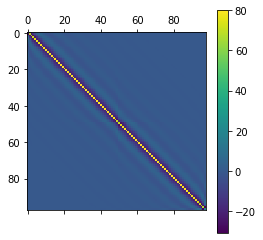

In [16]:
# Plot inverse power spectrum of signal+noise (masked channels removed before inverting)
plt.matshow(C_msk_inv)
plt.colorbar()
plt.show()

## Example power spectrum

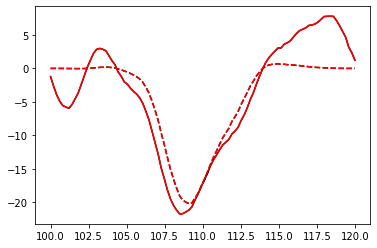

In [12]:
# Make tapering functions
from scipy.signal import blackmanharris
taper1 = blackmanharris(freqs.size)
taper2 = taper1[idxs]

# Plot data realisation (masked and unmasked versions)
plt.plot(freqs, d_inp.real, 'k-')
plt.plot(freqs_msk, d_msk.real, 'r-')

plt.plot(freqs, d_inp.real*taper1, 'k--')
plt.plot(freqs_msk, d_msk.real*taper2, 'r--')
plt.show()

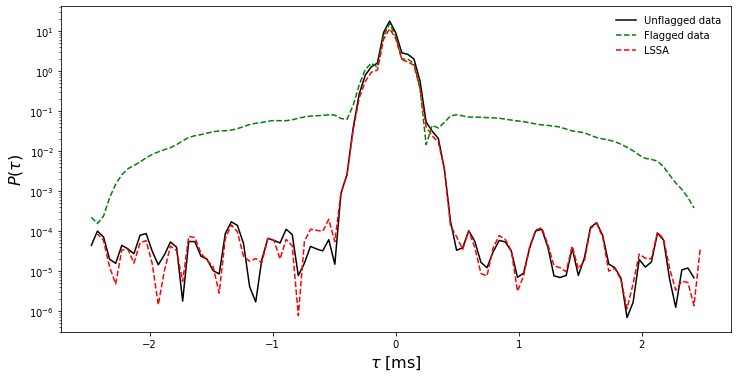

In [31]:
# Subtract means from masked/unmasked data
d_inp = d_inp - np.mean(d_inp)
d_msk = d_msk - np.mean(d_msk) # FIXME

# Estimate power spectrum
ps_inp = np.fft.ifft(taper1*d_inp).conj() * np.fft.ifft(taper1*d_inp)
ps_inp_msk = np.fft.ifft(taper1*d_inp*w).conj() * np.fft.ifft(taper1*d_inp*w)

tau_lssa, A_re_lssa, A_im_lssa = lssa_fit_modes(d=taper2*d_msk, invcov=C_msk_inv, freqs=freqs_msk, fit_amp_phase=False, tau=tau)
ps_lssa = 0.5 * (A_re_lssa**2. + A_im_lssa**2.)

# Plot power spectra
plt.subplot(111)

plt.plot(np.fft.fftshift(tau), np.fft.fftshift(ps_inp).real, 'k-', label="Unflagged data")
plt.plot(np.fft.fftshift(tau), np.fft.fftshift(ps_inp_msk).real, 'g--', label="Flagged data")

plt.plot(np.fft.fftshift(tau_lssa)*-1., 2.*np.fft.fftshift(ps_lssa), 'r--', label="LSSA")
plt.legend(loc='upper right', frameon=False)
plt.xlabel(r"$\tau$ [ms]", fontsize=16)
plt.ylabel(r"$P(\tau)$", fontsize=16)

plt.yscale('log')
#plt.ylim((1e-9, 1e2))
plt.gcf().set_size_inches((12., 6.))

## Gaussian Process Regression

In [524]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.kernel_ridge import KernelRidge

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern, RationalQuadratic, PairwiseKernel

GPR kernel (real): WhiteKernel(noise_level=0.000116) + RBF(length_scale=1.51) + Matern(length_scale=24.8, nu=1.5)
GPR kernel (imag): WhiteKernel(noise_level=7.5e-05) + RBF(length_scale=1.73) + Matern(length_scale=12.3, nu=1.5)


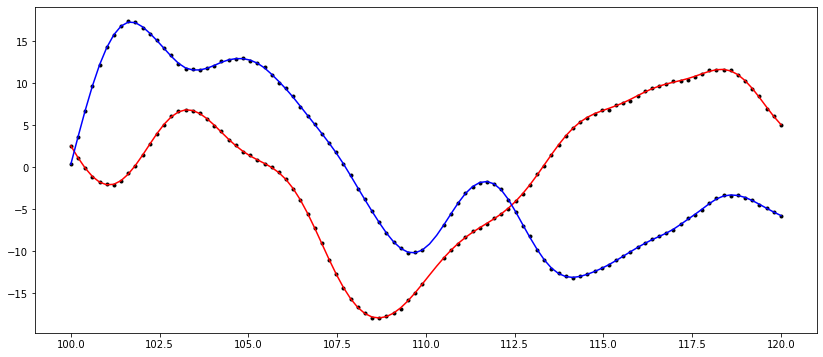

In [574]:
X_train = freqs_msk.reshape(-1,1).real
y_train = (d_msk - np.mean(d_msk)).reshape(-1,1)

X_test = freqs.reshape(-1,1).real
#y_test = y_train

# Gaussian Process Regression
kernel = WhiteKernel() + RBF(1.) + Matern()

gpr_re = GaussianProcessRegressor(kernel=kernel,
                                  random_state=0, 
                                  n_restarts_optimizer=4, 
                                  normalize_y=True).fit(X_train, y_train.real)
gpr_im = GaussianProcessRegressor(kernel=kernel,
                                  random_state=0, 
                                  n_restarts_optimizer=4, 
                                  normalize_y=True).fit(X_train, y_train.imag)
print("GPR kernel (real):", gpr_re.kernel_)
print("GPR kernel (imag):", gpr_im.kernel_)

#_x = np.linspace(500., 1700., 20)
#plt.plot(_x, _x, 'k--', lw=1.8)
plt.plot(X_train, y_train.real, 'k.')
plt.plot(X_train, y_train.imag, 'k.')
plt.plot(X_test, gpr_re.predict(X_test), 'r-')
plt.plot(X_test, gpr_im.predict(X_test), 'b-')
plt.gcf().set_size_inches((14., 6.))

# Goodness of fit score (r^2 = 1 is perfect fit, lower values = worse fit)
#print(f"GPR r^2: {gpr.score(X_test, y_test):.3f}")

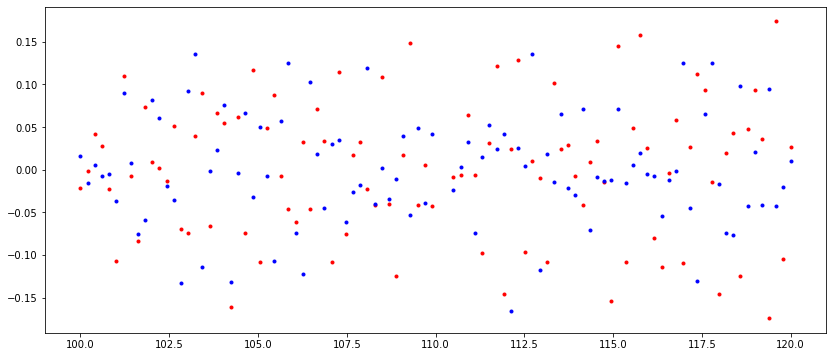

In [575]:
#plt.plot(X_train, y_train.real, 'k.')
#plt.plot(X_train, y_train.imag, 'k.')
plt.plot(X_train, gpr_re.predict(X_train) - y_train.real, 'r.')
plt.plot(X_train, gpr_im.predict(X_train) - y_train.imag, 'b.')
plt.gcf().set_size_inches((14., 6.))

(1e-08, 100.0)

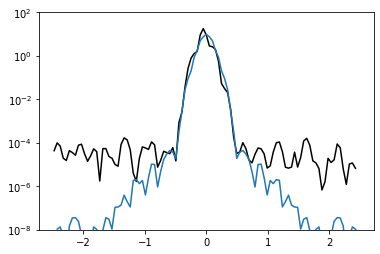

In [576]:
yy = (gpr_re.predict(X_test) + 1.j*gpr_im.predict(X_test)).flatten()
ps_gpr = np.fft.ifft(taper1 * yy.conj()) * np.fft.ifft(taper1 * yy)

plt.plot(np.fft.fftshift(tau), np.fft.fftshift(ps_inp).real, 'k-')
plt.plot(np.fft.fftshift(tau)*-1., np.fft.fftshift(np.abs(ps_gpr)))
plt.yscale('log')
plt.ylim((1e-8, 1e2))